In [1]:
import tensorflow as tf
if __name__=='__main__':
    tf.enable_eager_execution()
    
import os
import numpy as np

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Object Oriented CIFAR-10 Pipeline

In [14]:
class cifar10_loader(object):
    def __init__(self,filename,classes=10,batch_size=128,buffer_size=1024,prefetch=1):
        super(cifar10_loader,self).__init__()
        self.filename = filename
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.prefetch = prefetch
        
        self.train_images = None
        self.train_labels = None
        self.test_images = None
        self.test_labels = None
        #Self.fetch data will populate the above variables with data
        self.fetch_data()
        
        self.classes = classes
        self.train_data = self.datasetGenerator(self.train_images,self.train_labels)
        self.test_data = self.datasetGenerator(self.test_images,self.test_labels)
        self.mode = 'train'
        
        
    def fetch_data(self):
        def unpickle(file):
            import pickle
            with open(file, 'rb') as fo:
                d = pickle.load(fo, encoding='bytes')
            return d
    
        train_images = []
        train_labels = []
        
        #Prepare Training Data
        for batch_id in range(5):
            BATCH_NAME = "data_batch_" + str(batch_id+1)
            BATCH_PATH = os.path.join(self.filename,BATCH_NAME)
            d = unpickle(BATCH_PATH)
            images,labels = np.asarray(d[b'data']), np.asarray(d[b'labels'])
            train_images.append(images.reshape(-1,3,32,32))
            train_labels.append(labels)
            
        train_images = np.vstack(train_images)
        self.train_images = np.transpose(train_images,(0,2,3,1))
        self.train_labels = np.hstack(train_labels)
            
        #Prepare Test Data
        TEST_BATCH_PATH = os.path.join(self.filename,"test_batch")
        d = unpickle(TEST_BATCH_PATH)
        images,labels = d[b'data'],d[b'labels']
        self.test_images = np.transpose(images.reshape(-1,3,32,32),(0,2,3,1))
        self.test_labels = np.asarray(labels)
        
    def datasetGenerator(self,images,labels):
        def parseImage(image,label):
            return tf.image.resize_images(image,size=(227,227))/255.0,label
        
        dataset = tf.data.Dataset.from_tensor_slices((images,tf.one_hot(labels,depth=self.classes)))
        dataset = dataset.map(parseImage,num_parallel_calls=4)
        dataset = dataset.batch(batch_size = self.batch_size)
        dataset = dataset.prefetch(1)
        
        return dataset
    
    def __call__(self,mode):
        if mode=="train":
            for d in iter(self.train_data):
                yield d[0],d[1]
        elif mode=='test':
            for d in iter(self.test_data):
                yield d[0],d[1]
    

## Testing Code

(128, 227, 227, 3) (128, 10)
label  tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(10,), dtype=float32)


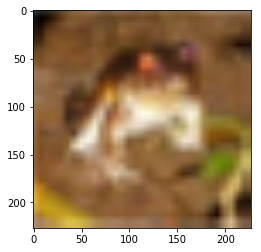

(128, 227, 227, 3) (128, 10)
label  tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)


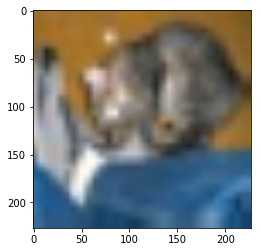

In [18]:
# Test your code!! This 'iter' works if eager execution is enabled.
if __name__=='__main__':
    CIFAR10_PATH = "../../Datasets/cifar-10-batches-py"
    #Create a DatasetObject
    dataset = cifar10_loader(CIFAR10_PATH)
    
    import matplotlib.pyplot as plt
    
    #Iterate over the dataset, batch by batch!
    for X,Y in dataset('train'):
        "Sample Image & Label"
        print(X.shape,Y.shape)
        print("label ",Y[0])
        plt.imshow(X[0])
        plt.show()
        break
    for X,Y in dataset('test'):
        "Sample Image & Label"
        print(X.shape,Y.shape)
        print("label ",Y[0])
        plt.imshow(X[0])
        plt.show()
        break
    